# **Image Colorization With GANs**

## **1. Loading and Processing the data**

In [1]:
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from keras.utils.vis_utils import plot_model
from matplotlib import image
from matplotlib import pyplot as plt
import os
from tensorflow import keras
tf.config.run_functions_eagerly(True)

batch_size = 64
img_size = 120
dataset_split = 2500

master_dir = '../input/image-colorization/data'
x = []
y = []
for image_file in os.listdir( master_dir )[ 0 : dataset_split ]:
    rgb_image = Image.open( os.path.join( master_dir , image_file ) ).resize( ( img_size , img_size ) )
    rgb_img_array = (np.asarray( rgb_image ) ) / 255
    gray_image = rgb_image.convert( 'L' )
    gray_img_array = ( np.asarray( gray_image ).reshape( ( img_size , img_size , 1 ) ) ) / 255
    x.append( gray_img_array )
    y.append( rgb_img_array )

train_x, test_x, train_y, test_y = train_test_split( np.array(x) , np.array(y) , test_size=0.1 )

dataset = tf.data.Dataset.from_tensor_slices( ( train_x , train_y ) )
dataset = dataset.batch( batch_size )


2022-05-30 09:55:15.474948: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 09:55:15.604777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 09:55:15.605629: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 09:55:15.615590: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## **2. The GAN**

### **A. Generator**

In [2]:
def get_generator_model():
    inputs = tf.keras.layers.Input( shape=( img_size , img_size , 1 ) )

    conv1 = tf.keras.layers.Conv2D( 16 , kernel_size=( 5 , 5 ) , strides=1 )( inputs )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )

    conv2 = tf.keras.layers.Conv2D( 32 , kernel_size=( 5 , 5 ) , strides=1)( conv1 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )

    conv3 = tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 )( conv2 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )

    bottleneck = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='tanh' , padding='same' )( conv3 )

    concat_1 = tf.keras.layers.Concatenate()( [ bottleneck , conv3 ] )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_1 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_3 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_3 )

    concat_2 = tf.keras.layers.Concatenate()( [ conv_up_3 , conv2 ] )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_2 )

    concat_3 = tf.keras.layers.Concatenate()( [ conv_up_2 , conv1 ] )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( concat_3 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( conv_up_1 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 3 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu')( conv_up_1 )

    model = tf.keras.models.Model( inputs , conv_up_1 )
    return model


### **B. Discriminator**

In [3]:
def get_discriminator_model():
    layers = [
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7 , 7 ) , strides=1 , activation='relu' , input_shape=( 120 , 120 , 3 ) ),
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7, 7 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense( 512, activation='relu'  )  ,
        tf.keras.layers.Dense( 128 , activation='relu' ) ,
        tf.keras.layers.Dense( 16 , activation='relu' ) ,
        tf.keras.layers.Dense( 1 , activation='sigmoid' ) 
    ]
    model = tf.keras.models.Sequential( layers )
    return model


### **C. Loss Functions**

In [4]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform( shape=real_output.shape , maxval=0.1 ) , real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform( shape=fake_output.shape , maxval=0.1  ) , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output , real_y):
    real_y = tf.cast( real_y , 'float32' )
    return mse( fake_output , real_y )

generator_optimizer = tf.keras.optimizers.Adam( 0.0005 )
discriminator_optimizer = tf.keras.optimizers.Adam( 0.0005 )

generator = get_generator_model()
discriminator = get_discriminator_model()


## **3. Training The GAN**

### **A. Create Train Function**

In [5]:
@tf.function
def train_step( input_x , real_y ):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate an image -> G( x )
        generated_images = generator( input_x , training=True)
        # Probability that the given image is real -> D( x )
        real_output = discriminator( real_y, training=True)
        # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = discriminator(generated_images, training=True)
        
        # L2 Loss -> || y - G(x) ||^2
        gen_loss = generator_loss( generated_images , real_y )
        # Log loss for the discriminator
        disc_loss = discriminator_loss( real_output, generated_output )
        
        losses["D"].append(disc_loss.numpy())
        losses["G"].append(gen_loss.numpy())
    
    #tf.keras.backend.print_tensor( tf.keras.backend.mean( gen_loss ) )
    #tf.keras.backend.print_tensor( gen_loss + disc_loss )

    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [6]:
generator.compile(
    optimizer=generator_optimizer,
    loss=generator_loss,
    metrics=['accuracy']
)

discriminator.compile(
    optimizer=discriminator_optimizer,
    loss=discriminator_loss,
    metrics=['accuracy']
)

### **B. Loading Model Weights**

In [7]:
loadmodel = True
genpath = '../input/image-colorization-notebook/gen_w.h5'
dispath = '../input/image-colorization-notebook/dis_w.h5'

In [8]:
genexist = os.path.exists(genpath)
disexist = os.path.exists(dispath)

In [9]:
if(genexist and disexist and loadmodel):
    print('loaded saved model weights')
    generator.load_weights(genpath)
    discriminator.load_weights(dispath)

loaded saved model weights


### **C. Training**

In [10]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    g_loss = []
    d_loss = []

    count = 0
    for i in losses['D']:
      count += 1
      if(count == 36):
        d_loss.append(i)
        count = 0

    count = 0   
    for i in losses['G']:
      count += 1
      if(count == 36):
        g_loss.append(i)
        count = 0

    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
num_epochs = 50
total_batch = len(list(dataset))
losses = {"D":[], "G":[]}

for e in range( num_epochs ):
    print(f'epocs : {e}')
    i=1
    for ( x , y ) in dataset:
        print(f'batch {i} of {total_batch} : {x.shape}')
        train_step( x , y )
        generator.save('gen.h5')       
        discriminator.save('dis.h5')
        generator.save_weights('gen_w.h5')
        discriminator.save_weights('dis_w.h5')
        i=i+1

2022-05-30 09:55:21.629992: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 777600000 exceeds 10% of free system memory.


epocs : 0


2022-05-30 09:55:23.010591: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 777600000 exceeds 10% of free system memory.


batch 1 of 36 : (64, 120, 120, 1)


2022-05-30 09:55:24.284831: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


batch 2 of 36 : (64, 120, 120, 1)
batch 3 of 36 : (64, 120, 120, 1)
batch 4 of 36 : (64, 120, 120, 1)
batch 5 of 36 : (64, 120, 120, 1)
batch 6 of 36 : (64, 120, 120, 1)
batch 7 of 36 : (64, 120, 120, 1)
batch 8 of 36 : (64, 120, 120, 1)
batch 9 of 36 : (64, 120, 120, 1)
batch 10 of 36 : (64, 120, 120, 1)
batch 11 of 36 : (64, 120, 120, 1)
batch 12 of 36 : (64, 120, 120, 1)
batch 13 of 36 : (64, 120, 120, 1)
batch 14 of 36 : (64, 120, 120, 1)
batch 15 of 36 : (64, 120, 120, 1)
batch 16 of 36 : (64, 120, 120, 1)
batch 17 of 36 : (64, 120, 120, 1)
batch 18 of 36 : (64, 120, 120, 1)
batch 19 of 36 : (64, 120, 120, 1)
batch 20 of 36 : (64, 120, 120, 1)
batch 21 of 36 : (64, 120, 120, 1)
batch 22 of 36 : (64, 120, 120, 1)
batch 23 of 36 : (64, 120, 120, 1)
batch 24 of 36 : (64, 120, 120, 1)
batch 25 of 36 : (64, 120, 120, 1)
batch 26 of 36 : (64, 120, 120, 1)
batch 27 of 36 : (64, 120, 120, 1)
batch 28 of 36 : (64, 120, 120, 1)
batch 29 of 36 : (64, 120, 120, 1)
batch 30 of 36 : (64, 120, 1

2022-05-30 09:56:45.549519: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 777600000 exceeds 10% of free system memory.


batch 1 of 36 : (64, 120, 120, 1)
batch 2 of 36 : (64, 120, 120, 1)
batch 3 of 36 : (64, 120, 120, 1)
batch 4 of 36 : (64, 120, 120, 1)
batch 5 of 36 : (64, 120, 120, 1)
batch 6 of 36 : (64, 120, 120, 1)
batch 7 of 36 : (64, 120, 120, 1)
batch 8 of 36 : (64, 120, 120, 1)
batch 9 of 36 : (64, 120, 120, 1)
batch 10 of 36 : (64, 120, 120, 1)
batch 11 of 36 : (64, 120, 120, 1)
batch 12 of 36 : (64, 120, 120, 1)
batch 13 of 36 : (64, 120, 120, 1)
batch 14 of 36 : (64, 120, 120, 1)
batch 15 of 36 : (64, 120, 120, 1)
batch 16 of 36 : (64, 120, 120, 1)
batch 17 of 36 : (64, 120, 120, 1)
batch 18 of 36 : (64, 120, 120, 1)
batch 19 of 36 : (64, 120, 120, 1)
batch 20 of 36 : (64, 120, 120, 1)
batch 21 of 36 : (64, 120, 120, 1)
batch 22 of 36 : (64, 120, 120, 1)
batch 23 of 36 : (64, 120, 120, 1)
batch 24 of 36 : (64, 120, 120, 1)
batch 25 of 36 : (64, 120, 120, 1)
batch 26 of 36 : (64, 120, 120, 1)
batch 27 of 36 : (64, 120, 120, 1)
batch 28 of 36 : (64, 120, 120, 1)
batch 29 of 36 : (64, 120, 12


## **4. Results**

We plotted the input, output and the original images respectively, from a part of the dataset to find out the results.


In [12]:
start,end, jump = 0,200,20

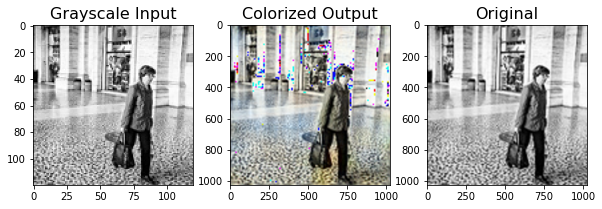

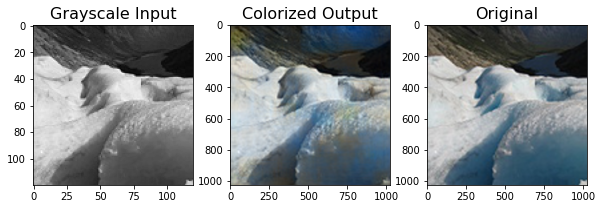

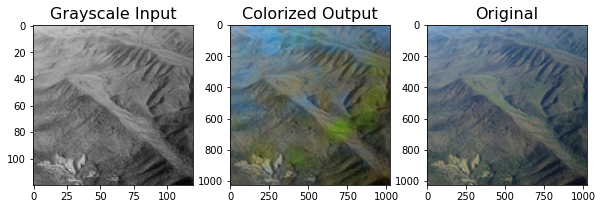

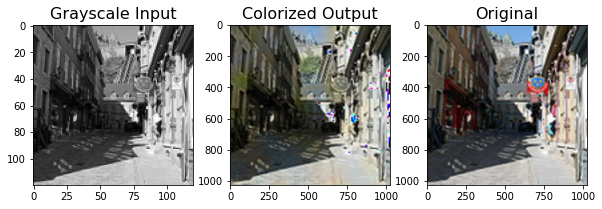

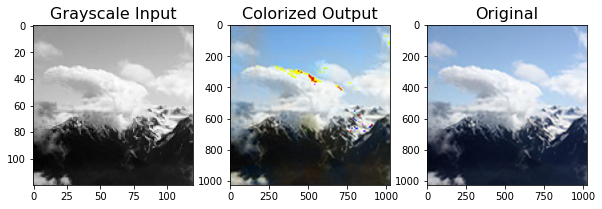

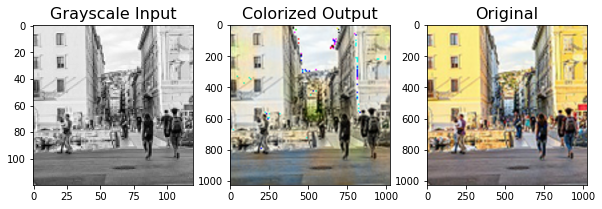

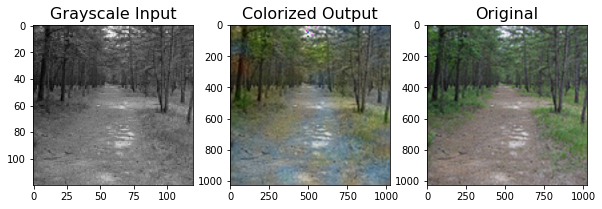

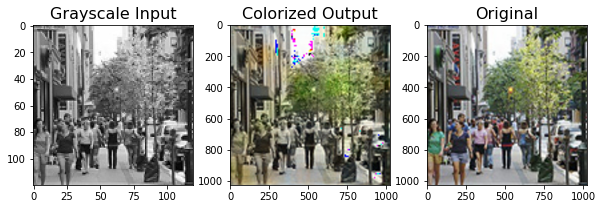

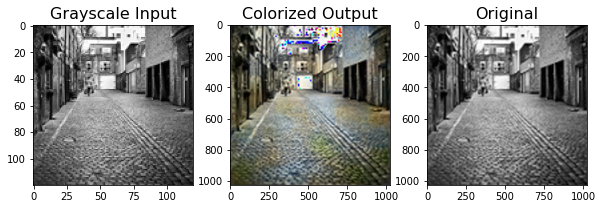

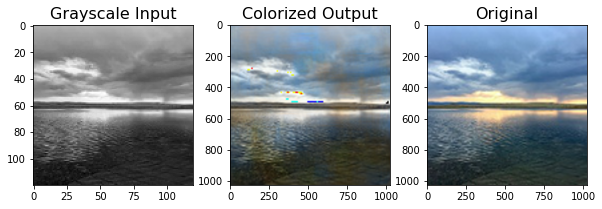

In [13]:
for i in range(start , end, jump):
    y = generator(np.array([test_x[i]])).numpy()
    plt.figure(figsize=(10,10))
    or_image = plt.subplot(3,3,1)
    or_image.set_title('Grayscale Input', fontsize=16)
    plt.imshow( test_x[i].reshape((120,120)) , cmap='gray' )

    in_image = plt.subplot(3,3,2)    
    image = Image.fromarray( ( y[0] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
    image = np.asarray( image )
    in_image.set_title('Colorized Output', fontsize=16)
    plt.imshow( image )

    ou_image = plt.subplot(3,3,3)
    image = Image.fromarray( ( test_y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
    ou_image.set_title('Original', fontsize=16)
    plt.imshow( image )

    plt.show()

## **5. Plots**

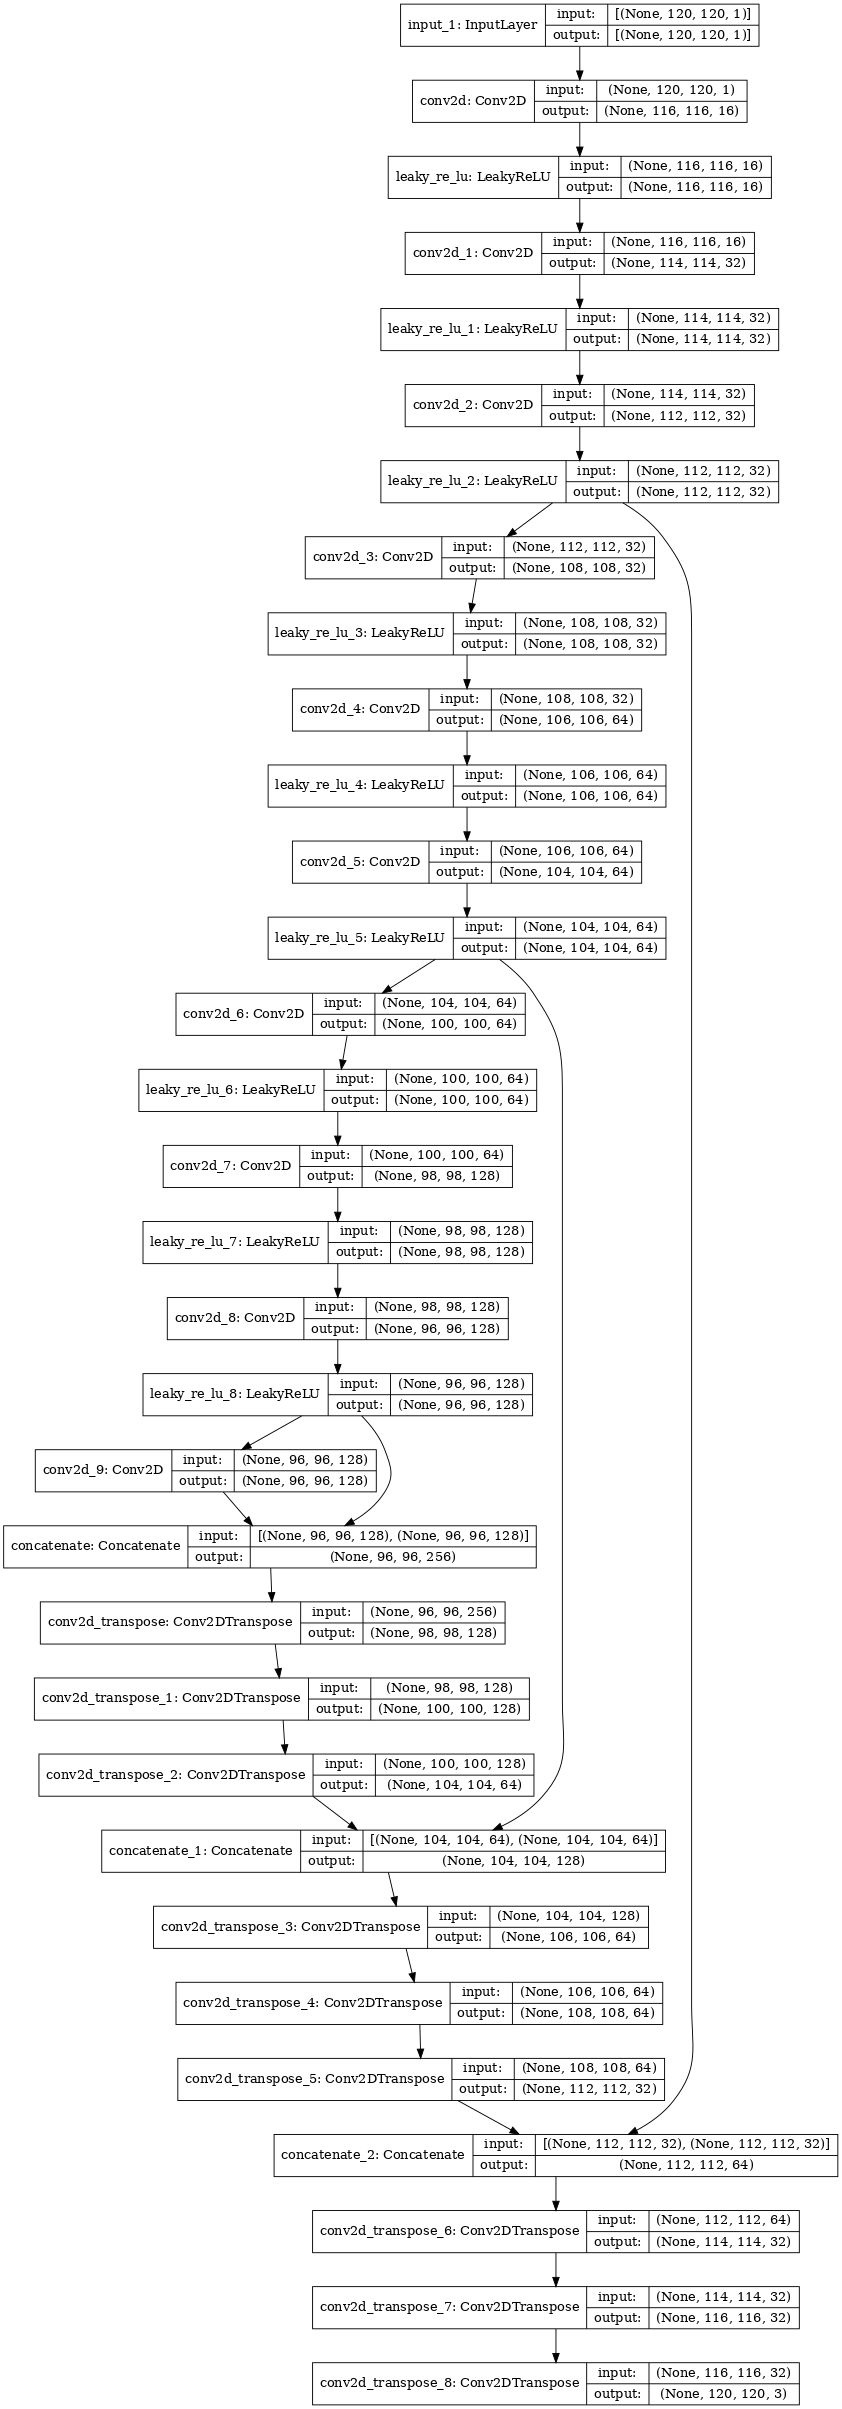

In [14]:
plot_model(generator, to_file='generator.png', show_shapes=True, show_layer_names=True, dpi=66)

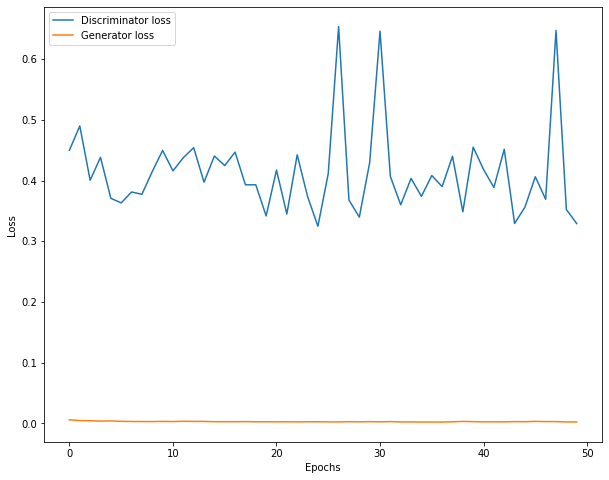

In [15]:
plot_loss(losses)